In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import optimize
from altaipony.altai import aflare

from funcs.read import get_cutout, get_dataframe, get_events_and_bg

In [2]:
def sin_func(x, a, b, c):
    return a * np.sin(2 * np.pi * x + b) + c


def lin_func(x, a, b):
    return a * x + b



In [3]:
# three detectors
detectors = ["mos1", "mos2", "pn"]

# get the paths to data
paths = [f"../data/xmm/2022-10-05-095929/{x}.fits" for x in detectors]

# get the events and background
data = [(detector, get_events_and_bg(path)) for detector, path in list(zip(detectors,paths))]


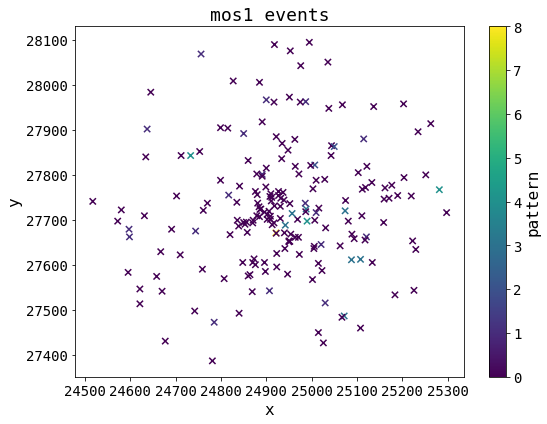

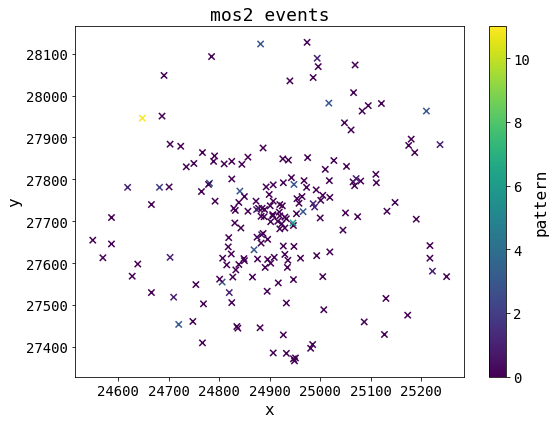

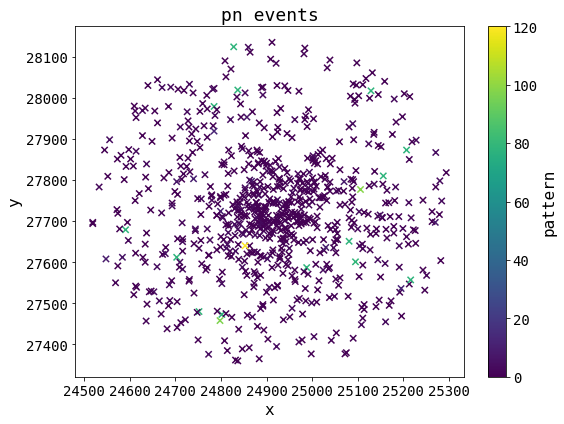

In [4]:
# Plot events cutouts
for d in data:
    # events
    events = d[1][0]
    detector = d[0]
    events.groupby(["x","y"]).time.count().reset_index()
    fig, ax = plt.subplots(figsize=(8,6))
    events.plot.scatter(x="x",y="y",c="pattern",cmap="viridis",s=40, ax=ax)
    ax.set_title(f"{detector} events")

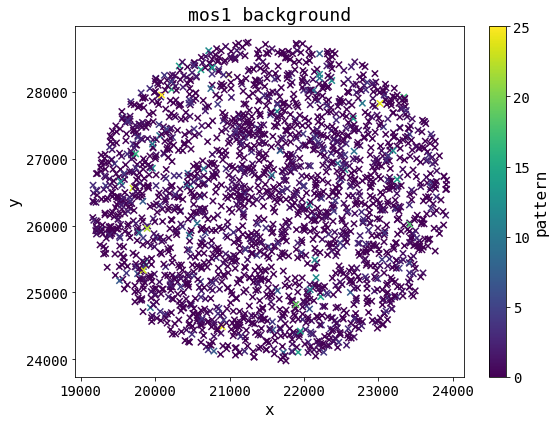

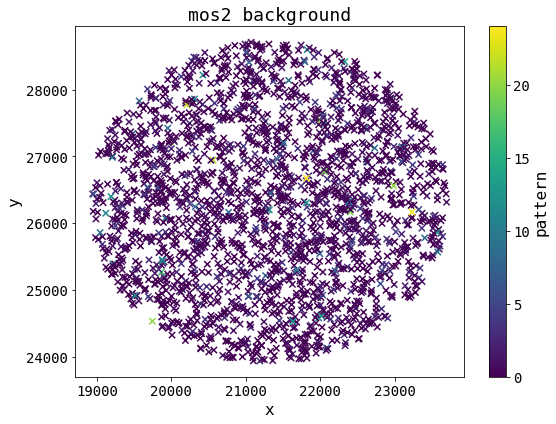

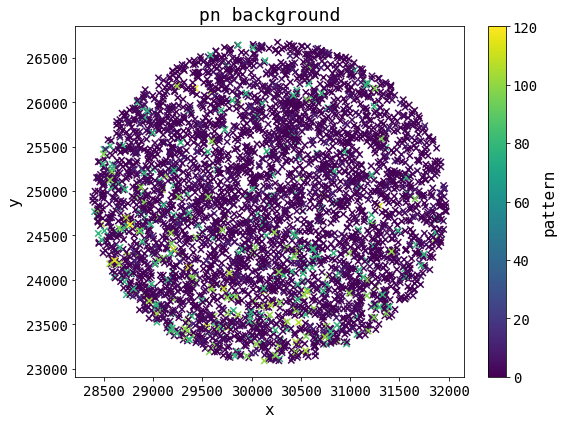

In [5]:
# plot background cutouts
for d in data:
    # events
    events = d[1][1]
    detector = d[0]
    events.groupby(["x","y"]).time.count().reset_index()
    fig, ax = plt.subplots(figsize=(8,6))
    events.plot.scatter(x="x",y="y",c="pattern",cmap="viridis",s=40, ax=ax)
    ax.set_title(f"{detector} background")

Text(0.5, 0, 'rotational phase')

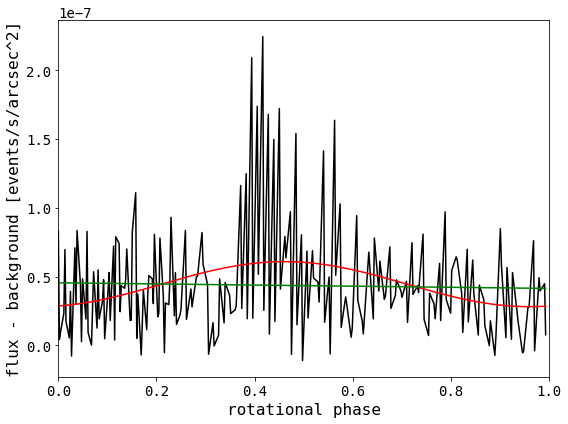

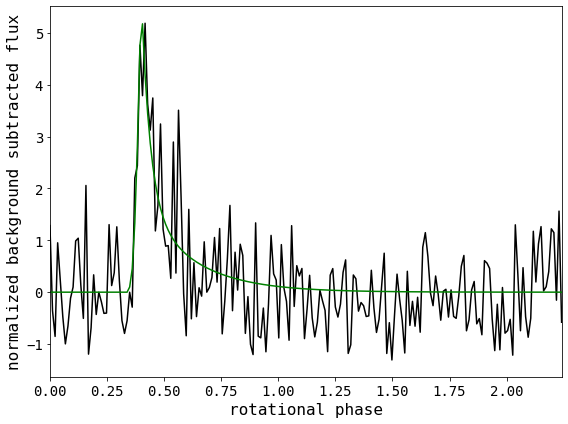

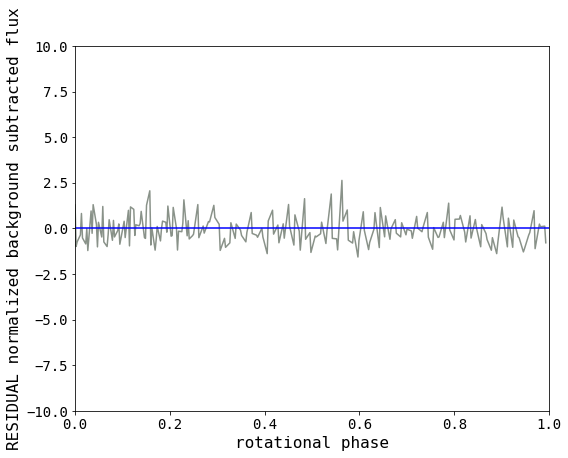

In [6]:

# number of bins
nbins = 200

# init the time series in the length of the bins
hist = np.zeros(nbins)
bg = np.zeros(nbins)

# init the collection per detector
hists = []
bgs = []

# define t0 as the earliest observing time in the data
t0 = 776069941.4247829

# define the time bins to encompass all observations
bins = np.linspace(t0, 776106911.7128757, nbins + 1)

# loop over the data
for d in data:
    # events
    events = d[1][0]
    # radius
    r = d[1][2][2]
    
    # bin the events
    events_hist, _ = np.histogram(events.time, bins=bins)

    # get the area of the cutout
    events_a = np.pi * r**2

    # get the flux density
    events_hist = events_hist / events_a

    # add the flux to the stacked data
    hist += events_hist

    # add the flux to the detector collection
    hists.append(events_hist)

    # bkg
    bkg = d[1][1]

    # radius
    rbg = d[1][3][2]

    # bin the background
    bkg_hist, _ = np.histogram(bkg.time, bins=bins)

    # get the area of the cutout
    bkg_a = np.pi * rbg**2

    # get the flux density
    bkg_hist = bkg_hist / bkg_a

    # add the flux to the stacked data
    bg += bkg_hist

    # add the flux to the detector collection
    bgs.append(bkg_hist)

# caclulate the centers of the bins
binmids = (bins[1:] + bins[:-1]) / 2

# calculate the observing time per bin
dt = bins[1] - bins[0]

# rotation period of TIC 277 in seconds
rotper = 4.56 * 60 * 60 # seconds

# calculate the rotational phase
phase = (binmids - binmids[0]) / rotper % 1

# convert histogram of events and phase to pandas DataFrame
dd = pd.DataFrame({"hist": hist, "bg": bg, "phase": phase})

# sort by phase
dd = dd.sort_values("phase", ascending=True)

# calculate the counts above background per time
flux = (dd["hist"]-dd.bg)/dt


# plot the light curve
plt.figure(figsize=(8,6))
plt.plot(dd.phase, flux, c="k")

# fit and plot sinusoidal model
params, pcov = optimize.curve_fit(sin_func, dd.phase.values, flux.values,
                                               p0=[2e-8, 1., 2e-8])
plt.plot(dd.phase, sin_func(dd.phase.values, *params), c="r")


# fit and plot linear model
params, pcov = optimize.curve_fit(lin_func, dd.phase.values, flux.values,
                                               p0=[2, 2])
plt.plot(dd.phase, lin_func(dd.phase.values, *params), c="green")

# labels and limits and stuff
plt.ylabel("flux - background [events/s/arcsec^2]")
plt.xlabel("rotational phase")
plt.xlim(0,1)
# plt.ylim(0,)


# fit a flare light curve to the data
plt.figure(figsize=(8,6))

# define phase but don't fold
phase = (binmids - binmids[0]) / rotper

# without folding no conversion to DataFrame needed, just use flux
# as is, subtract background and divide by dt
flux = (hist-bg)/dt

# plot the light curve
plt.plot(phase, flux/np.median(flux)-1., c="k")

# fit the flare light curve and plot
params, pcov = optimize.curve_fit(aflare, phase, flux/np.median(flux)-1.,
                                               p0=[.4, .02, .1])
plt.plot(phase, aflare(phase, *params), c="green")

# labels and limits and stuff
plt.ylabel("normalized background subtracted flux")
plt.xlabel("rotational phase")
plt.xlim(phase[0],phase[-1])



# plot the residuals
plt.figure(figsize=(8,6))

# now we need a DataFrame again because we phase fold
# subtract the flare fit from the data
dd = pd.DataFrame({"phase":phase%1.,
                   "flux":flux/np.median(flux)-1. - aflare(phase, *params)})
# sort data by phase then and plot
dd = dd.sort_values("phase")
plt.plot(dd.phase, dd.flux)

# add a horizontal line at zero
plt.plot([0,1],[0,0], c="blue")

# labels and limits and stuff
plt.ylim(-10,10)
plt.xlim(0,1)
plt.ylabel("RESIDUAL normalized background subtracted flux")
plt.xlabel("rotational phase")

/home/ekaterina/Documents/000_envs/fleck38/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(776089000.0, 776092000.0)

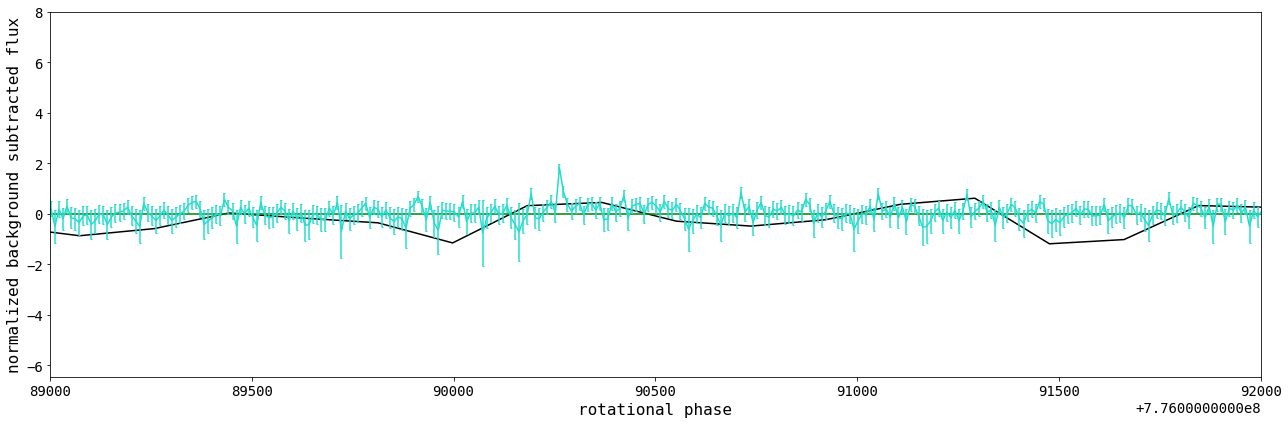

In [46]:
paths = [f"../data/xmm/om/P0901200101OMS00{n}TIMESR0000.FIT" for n in range(1,9)]
timeseries = pd.DataFrame()

for path in paths:
    hdr = fits.open(path)[1]
    time = hdr.data["TIME"]
    rate = hdr.data["RATE"]
    err = hdr.data["ERROR"]
    

# fit a flare light curve to the data
plt.figure(figsize=(18,6))

# define phase but don't fold
phase = binmids

# without folding no conversion to DataFrame needed, just use flux
# as is, subtract background and divide by dt
flux = (hist-bg)/dt

# plot the light curve
plt.plot(phase, flux/np.median(flux)-1., c="k")

# fit the flare light curve and plot
params, pcov = optimize.curve_fit(aflare, phase, flux/np.median(flux)-1.,
                                               p0=[7.76075e8, .2, .3])
plt.plot(phase, aflare(phase, *params), c="green")

for path in paths:
    hdr = fits.open(path)[1]
    time = hdr.data["TIME"]
    rate = hdr.data["RATE"]
    err = hdr.data["ERROR"]
    df = pd.DataFrame({"time":time,
                "rate":rate,
                "err":err})   
    rolled = df.rolling(window=5, center=True).mean()
    # plt.plot(rolled.time, (rolled.rate/np.nanmedian(rolled.rate)-1)*3., alpha=1)

    plt.errorbar(time, (rate/np.nanmedian(rate)-1), yerr=err/rate, alpha=1, capsize=1)

# plt.scatter(timeseries.time, (timeseries.rate/np.median(timeseries.rate)-1)*3, c="red", s=3)

# rolled = timeseries.rolling(window=10, center=True).mean()

# # print(np.nanmedian(rolled.rate))
# plt.plot(rolled.time, (rolled.rate/np.nanmedian(rolled.rate)-1)*3., c="r")

# labels and limits and stuff
plt.ylabel("normalized background subtracted flux")
plt.xlabel("rotational phase")
plt.xlim(phase[0],phase[-1])

# plt.xlim(7.76075e+08, 7.76083e+08) # xray flare
# plt.xlim(7.76104e8, 7.76106e8) # outlier in the end
plt.xlim(7.76089e8, 7.76092e8) # another flare

# plt.ylim(-2,6)


[0.00572389 0.00568605 0.00564825 ... 0.00583763 0.00579968 0.00576177]


array([-0.0101851 ,  0.23897055,  0.0081518 ])

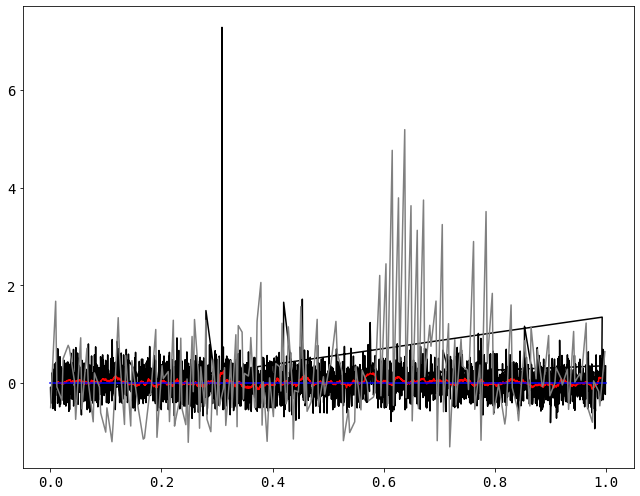

In [8]:

def sin_func(x, a, b, c):
    return a * np.sin(2 * np.pi * x  + b) + c

plt.figure(figsize=(9,7))
timeseries["phase"] = timeseries.time / rotper  % 1.
timeseries["normrate"] = timeseries.rate / np.median(timeseries.rate) - 1.
plt.plot(timeseries.phase, timeseries.normrate, c="k")
# plt.ylim(-1.5,1.5)
timeseries = timeseries.sort_values("phase")
# binned_timeseries = timeseries.groupby(pd.cut(timeseries.phase, np.linspace(0,1,500)))
# binned_time = binned_timeseries.phase.mean()
# binned_rate = binned_timeseries.rate.sum()

# plt.plot(binned_time, binned_rate)

params, pcov = optimize.curve_fit(sin_func, timeseries.phase.values, timeseries.normrate.values, p0=[.1, .9, 0.1,])
print(sin_func(timeseries.phase.values, *params))
rolled = timeseries.rolling(window=40, center=True).mean()

plt.plot(rolled.phase, rolled.normrate, c="r")
plt.plot([0,1],[0,0], c="blue")
# plt.plot(timeseries.phase.values, sin_func(timeseries.phase.values, *params),c="orange", lw=3)
df = pd.DataFrame({"phase":phase/rotper%1, "flux":flux/np.median(flux)-1}).sort_values("phase")
plt.plot(df.phase, df.flux, c="grey")
params

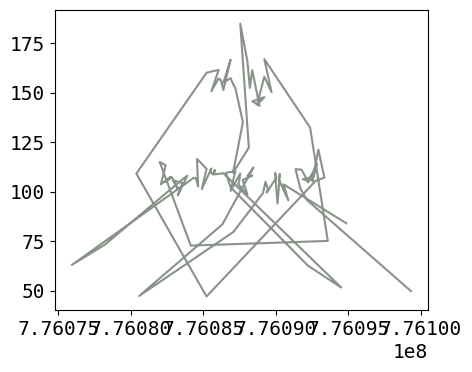

In [38]:
plt.plot(binned_time, binned_rate)

In [51]:
binned_timeseries["rate"].sum()

phase
(0.0, 0.0001]          0.000000
(0.0001, 0.0002]       0.000000
(0.0002, 0.0003]       2.887214
(0.0003, 0.0004]       0.000000
(0.0004, 0.0005001]    0.000000
                         ...   
(0.9995, 0.9996]       0.000000
(0.9996, 0.9997]       4.284628
(0.9997, 0.9998]       0.000000
(0.9998, 0.9999]       0.000000
(0.9999, 1.0]          0.000000
Name: rate, Length: 9999, dtype: float64